February 10, 2026

# Model 6: 3D U-Net for BraTS 2020

**Key Changes from Model 5 (2D):**
- Full 3D volumetric convolutions
- Patch-based training (128³ patches from 240×240×155 volumes)
- Mixed precision training (FP16) for memory efficiency
- Gradient checkpointing to fit in GPU memory
- Sliding window inference with Gaussian weighting

**Requirements:**
- GPU with 16-24GB VRAM (V100/A10G recommended)
- Original BraTS NIfTI files

# Imports

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import time
import sys

# Add path to utils
sys.path.insert(0, '/home/sagemaker-user/BraTS-2020-CV-Project')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.6.0
CUDA available: True
GPU: NVIDIA A10G
GPU Memory: 23.7 GB


## 1. 3D U-Net Architecture (with GroupNorm)

**Key change:** Using GroupNorm instead of BatchNorm for stability with batch_size=1

In [12]:
class ConvBlock3D(nn.Module):
    """
    3D Convolution Block: Conv3D -> GroupNorm -> ReLU (x2)
    
    Using GroupNorm instead of BatchNorm because:
    - BatchNorm is unstable with batch_size=1 (noisy statistics)
    - GroupNorm computes stats over groups of channels, independent of batch size
    - num_groups=8 is a good default (or 16 for larger channel counts)
    """
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        # Ensure num_groups divides out_channels
        num_groups = min(num_groups, out_channels)
        while out_channels % num_groups != 0:
            num_groups -= 1
        
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.gn1 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.gn2 = nn.GroupNorm(num_groups, out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.relu(self.gn1(self.conv1(x)))
        x = self.relu(self.gn2(self.conv2(x)))
        return x


class EncoderBlock3D(nn.Module):
    """Encoder block: ConvBlock -> MaxPool3D"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock3D(in_channels, out_channels)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
    
    def forward(self, x):
        conv_out = self.conv(x)
        pooled = self.pool(conv_out)
        return conv_out, pooled


class DecoderBlock3D(nn.Module):
    """Decoder block: Upsample -> Concat skip -> ConvBlock"""
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.upsample = nn.ConvTranspose3d(in_channels, in_channels // 2, 
                                            kernel_size=2, stride=2)
        self.conv = ConvBlock3D(in_channels // 2 + skip_channels, out_channels)
    
    def forward(self, x, skip):
        x = self.upsample(x)
        
        # Handle size mismatch
        if x.shape != skip.shape:
            diff_d = skip.size(2) - x.size(2)
            diff_h = skip.size(3) - x.size(3)
            diff_w = skip.size(4) - x.size(4)
            x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                         diff_h // 2, diff_h - diff_h // 2,
                         diff_d // 2, diff_d - diff_d // 2])
        
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


class UNet3D(nn.Module):
    """
    3D U-Net with GroupNorm for volumetric segmentation.
    
    Architecture:
    - 4 encoder levels (32 -> 64 -> 128 -> 256 channels)
    - Bottleneck (512 channels)
    - 4 decoder levels with skip connections
    - GroupNorm for batch-size-independent normalization
    - Optional gradient checkpointing
    """
    def __init__(self, in_channels=4, num_classes=4, base_features=32, use_checkpointing=False):
        super().__init__()
        self.use_checkpointing = use_checkpointing
        
        f = base_features
        
        # Encoder
        self.enc1 = EncoderBlock3D(in_channels, f)      # 32
        self.enc2 = EncoderBlock3D(f, f * 2)            # 64
        self.enc3 = EncoderBlock3D(f * 2, f * 4)        # 128
        self.enc4 = EncoderBlock3D(f * 4, f * 8)        # 256
        
        # Bottleneck
        self.bottleneck = ConvBlock3D(f * 8, f * 16)    # 512
        
        # Decoder
        self.dec4 = DecoderBlock3D(f * 16, f * 8, f * 8)
        self.dec3 = DecoderBlock3D(f * 8, f * 4, f * 4)
        self.dec2 = DecoderBlock3D(f * 4, f * 2, f * 2)
        self.dec1 = DecoderBlock3D(f * 2, f, f)
        
        # Final layer
        self.final = nn.Conv3d(f, num_classes, kernel_size=1)
    
    def forward(self, x):
        if self.use_checkpointing and self.training:
            skip1, x = checkpoint(self.enc1, x, use_reentrant=False)
            skip2, x = checkpoint(self.enc2, x, use_reentrant=False)
            skip3, x = checkpoint(self.enc3, x, use_reentrant=False)
            skip4, x = checkpoint(self.enc4, x, use_reentrant=False)
            x = checkpoint(self.bottleneck, x, use_reentrant=False)
        else:
            skip1, x = self.enc1(x)
            skip2, x = self.enc2(x)
            skip3, x = self.enc3(x)
            skip4, x = self.enc4(x)
            x = self.bottleneck(x)
        
        x = self.dec4(x, skip4)
        x = self.dec3(x, skip3)
        x = self.dec2(x, skip2)
        x = self.dec1(x, skip1)
        
        return self.final(x)


# Test model
def test_model():
    model = UNet3D(in_channels=4, num_classes=4, base_features=32, use_checkpointing=True)
    model = model.cuda()
    
    params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {params:,} ({params/1e6:.1f}M)")
    
    x = torch.randn(1, 4, 128, 128, 128).cuda()
    
    with torch.no_grad():
        torch.cuda.reset_peak_memory_stats()
        y = model(x)
        mem = torch.cuda.max_memory_allocated() / 1e9
    
    print(f"Input shape: {x.shape}")
    print(f"Output shape: {y.shape}")
    print(f"Peak GPU memory (inference): {mem:.2f} GB")
    print(f"Normalization: GroupNorm (batch-size independent) ✓")
    
    del model, x, y
    torch.cuda.empty_cache()

test_model()

Model parameters: 22,580,964 (22.6M)
Input shape: torch.Size([1, 4, 128, 128, 128])
Output shape: torch.Size([1, 4, 128, 128, 128])
Peak GPU memory (inference): 2.25 GB
Normalization: GroupNorm (batch-size independent) ✓


## 2. Configuration

In [13]:
# Paths - UPDATE FOR YOUR SETUP
DATA_DIR = Path("/home/sagemaker-user/brats-training-data/MICCAI_BraTS2020_TrainingData")
OUTPUT_DIR = Path("/home/sagemaker-user/BraTS-2020-CV-Project")
OUTPUT_DIR.mkdir(exist_ok=True)

CONFIG = {
    # Architecture
    'in_channels': 4,
    'num_classes': 4,
    'base_features': 32,
    'use_checkpointing': True,
    
    # Data
    'patch_size': (128, 128, 128),
    'samples_per_volume': 4,
    'val_patches_per_volume': 8,  # Multi-patch validation
    'tumor_center_prob': 0.85,    # Higher early on helps
    
    # Training
    'batch_size': 1,
    'num_epochs': 100,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'use_amp': True,
    
    # Loss
    'ce_weight': 1.0,
    'dice_weight': 1.0,
    'ce_class_weights': [0.1, 1.0, 1.0, 1.0],
    'dice_class_weights': [1.0, 1.0, 1.5],  # NCR, ED, ET (emphasize ET)
    
    # Validation
    'full_volume_val_every': 10,  # Full sliding window val every N epochs
    
    # Inference (OPTIMIZED: batched sliding window)
    'inference_overlap': 0.5,
    'inference_batch_size': 2,    # Process 2-4 patches at once (2-3x faster)
    
    # Data split
    'train_ratio': 0.7,
    'val_ratio': 0.15,
    'seed': 42,
    
    # Performance (adjust based on your hardware)
    'num_workers': 2,             # Increase to 4-8 if CPU is bottleneck
    'use_cache': False,           # Set True if RAM > 32GB
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  in_channels: 4
  num_classes: 4
  base_features: 32
  use_checkpointing: True
  patch_size: (128, 128, 128)
  samples_per_volume: 4
  val_patches_per_volume: 8
  tumor_center_prob: 0.85
  batch_size: 1
  num_epochs: 100
  learning_rate: 0.0001
  weight_decay: 1e-05
  use_amp: True
  ce_weight: 1.0
  dice_weight: 1.0
  ce_class_weights: [0.1, 1.0, 1.0, 1.0]
  dice_class_weights: [1.0, 1.0, 1.5]
  full_volume_val_every: 10
  inference_overlap: 0.5
  inference_batch_size: 2
  train_ratio: 0.7
  val_ratio: 0.15
  seed: 42
  num_workers: 2
  use_cache: False


## 3. Load Data

In [14]:
# Import from FIXED utils
from brats_utils_3d import (
    BraTSDataset3D, 
    get_patient_ids, 
    train_val_test_split,
    CombinedLoss,
    dice_per_class,
    dice_brats_regions,  # NEW: WT/TC/ET dice
    compute_brats_metrics,
    sliding_window_inference,
    load_patient_volume
)

# Get patient IDs
all_patient_ids = get_patient_ids(DATA_DIR)
print(f"Found {len(all_patient_ids)} patients")

# Split data
train_ids, val_ids, test_ids = train_val_test_split(
    all_patient_ids, 
    train_ratio=CONFIG['train_ratio'],
    val_ratio=CONFIG['val_ratio'],
    seed=CONFIG['seed']
)

print(f"Train: {len(train_ids)} patients")
print(f"Val: {len(val_ids)} patients")
print(f"Test: {len(test_ids)} patients")

Found 369 patients
Train: 258 patients
Val: 55 patients
Test: 56 patients


In [15]:
# Create datasets with FIXED multi-patch validation
train_dataset = BraTSDataset3D(
    data_dir=DATA_DIR,
    patient_ids=train_ids,
    patch_size=CONFIG['patch_size'],
    augment=True,
    mode='train',
    samples_per_volume=CONFIG['samples_per_volume'],
    tumor_center_prob=CONFIG['tumor_center_prob']
)
train_dataset.use_cache = CONFIG['use_cache']

val_dataset = BraTSDataset3D(
    data_dir=DATA_DIR,
    patient_ids=val_ids,
    patch_size=CONFIG['patch_size'],
    augment=False,
    mode='val',
    val_patches_per_volume=CONFIG['val_patches_per_volume']  # 8 patches per volume
)
val_dataset.use_cache = CONFIG['use_cache']

print(f"Train samples per epoch: {len(train_dataset)}")
print(f"Val samples (multi-patch): {len(val_dataset)} ({CONFIG['val_patches_per_volume']} patches × {len(val_ids)} patients)")

# DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

Train samples per epoch: 1032
Val samples (multi-patch): 440 (8 patches × 55 patients)


In [16]:
# Verify data + label remapping
print("Checking data loading and label remapping...")
for i in range(min(3, len(train_dataset))):
    img, seg = train_dataset[i]
    labels = torch.unique(seg).tolist()
    print(f"  Sample {i}: shape={seg.shape}, labels={labels}")
    
    # Verify no label 4 (should be remapped to 3)
    assert 4 not in labels, f"Label 4 found! Remap failed."
    
print("✓ Labels correctly remapped (no label 4)")

Checking data loading and label remapping...
  Sample 0: shape=torch.Size([128, 128, 128]), labels=[0, 1, 2, 3]
  Sample 1: shape=torch.Size([128, 128, 128]), labels=[0, 1, 2, 3]
  Sample 2: shape=torch.Size([128, 128, 128]), labels=[0, 1, 2, 3]
✓ Labels correctly remapped (no label 4)


## 4. Initialize Model, Optimizer, Loss

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model with GroupNorm
model = UNet3D(
    in_channels=CONFIG['in_channels'],
    num_classes=CONFIG['num_classes'],
    base_features=CONFIG['base_features'],
    use_checkpointing=CONFIG['use_checkpointing']
).to(device)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss with class weights for both CE and Dice
criterion = CombinedLoss(
    num_classes=CONFIG['num_classes'],
    ce_weight=CONFIG['ce_weight'],
    dice_weight=CONFIG['dice_weight'],
    class_weights=CONFIG['ce_class_weights'],
    dice_class_weights=CONFIG['dice_class_weights']
).to(device)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=CONFIG['num_epochs'], eta_min=1e-6
)

# AMP scaler
scaler = GradScaler('cuda') if CONFIG['use_amp'] else None

print(f"\n✓ Model: 3D U-Net with GroupNorm")
print(f"✓ Loss: CE (weights={CONFIG['ce_class_weights']}) + Dice (weights={CONFIG['dice_class_weights']})")
print(f"✓ Optimizer: AdamW (lr={CONFIG['learning_rate']})")

Using device: cuda
Parameters: 22,580,964

✓ Model: 3D U-Net with GroupNorm
✓ Loss: CE (weights=[0.1, 1.0, 1.0, 1.0]) + Dice (weights=[1.0, 1.0, 1.5])
✓ Optimizer: AdamW (lr=0.0001)


## 5. Training Functions

In [22]:
def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    """Train for one epoch, return loss and BraTS region dice"""
    model.train()
    total_loss = 0
    region_dice = {'WT': [], 'TC': [], 'ET': []}
    
    pbar = tqdm(loader, desc="Training", leave=False)
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        
        if scaler is not None:
            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
        
        # Compute BraTS region dice (WT/TC/ET)
        preds = torch.argmax(outputs, dim=1)
        for b in range(preds.shape[0]):
            dice = dice_brats_regions(preds[b], masks[b])
            for k in dice:
                region_dice[k].append(dice[k])
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Average region dice
    avg_dice = {k: np.mean(v) for k, v in region_dice.items()}
    
    return total_loss / len(loader), avg_dice


def validate_patches(model, loader, criterion, device):
    """Validate on multi-patch samples"""
    model.eval()
    total_loss = 0
    region_dice = {'WT': [], 'TC': [], 'ET': []}
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Val (patches)", leave=False):
            images = images.to(device)
            masks = masks.to(device)
            
            if CONFIG['use_amp']:
                with autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
            else:
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            for b in range(preds.shape[0]):
                dice = dice_brats_regions(preds[b], masks[b])
                for k in dice:
                    region_dice[k].append(dice[k])
    
    avg_dice = {k: np.mean(v) for k, v in region_dice.items()}
    
    return total_loss / len(loader), avg_dice


def validate_full_volume(model, patient_ids, data_dir, device, num_patients=5):
    """
    Full-volume validation using sliding window inference.
    Run periodically (every N epochs) for true performance estimate.
    """
    model.eval()
    metrics_list = []
    
    # Sample subset for speed
    sample_ids = patient_ids[:num_patients]
    
    for patient_id in tqdm(sample_ids, desc="Val (full-vol)", leave=False):
        image, target, _ = load_patient_volume(data_dir, patient_id)
        if target is None:
            continue
        
        pred = sliding_window_inference(
            model, image,
            patch_size=CONFIG['patch_size'],
            overlap=CONFIG['inference_overlap'],
            device=device,
            use_amp=CONFIG['use_amp'],
            batch_size=CONFIG['inference_batch_size']
        )
        
        metrics = compute_brats_metrics(pred, target)
        metrics_list.append(metrics)
    
    # Average
    avg_metrics = {}
    for key in ['WT_Dice', 'TC_Dice', 'ET_Dice']:
        avg_metrics[key] = np.mean([m[key] for m in metrics_list])
    
    return avg_metrics

## 5b. Sanity Check: Overfit 1 Patient

Run this BEFORE full training to verify the model can learn.

In [20]:
def sanity_check_overfit(model, patient_id, data_dir, device, num_iters=200):
    """
    Overfit on a single patient to verify model can learn.
    Dice should shoot up quickly if everything is working.
    """
    print(f"Sanity check: overfitting on {patient_id}...")
    
    # Create single-patient dataset
    dataset = BraTSDataset3D(
        data_dir=data_dir,
        patient_ids=[patient_id],
        patch_size=(128, 128, 128),
        augment=False,
        mode='train',
        samples_per_volume=1,
        tumor_center_prob=1.0  # Always center on tumor
    )
    
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # Fresh model
    test_model = UNet3D(in_channels=4, num_classes=4, base_features=32).to(device)
    optimizer = torch.optim.Adam(test_model.parameters(), lr=1e-3)
    criterion = CombinedLoss(num_classes=4).to(device)
    
    test_model.train()
    
    for i in range(num_iters):
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = test_model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            if (i + 1) % 50 == 0:
                preds = torch.argmax(outputs, dim=1)
                dice = dice_brats_regions(preds[0], masks[0])
                print(f"  Iter {i+1}: Loss={loss.item():.4f}, WT={dice['WT']:.3f}, TC={dice['TC']:.3f}, ET={dice['ET']:.3f}")
    
    # Final check
    preds = torch.argmax(outputs, dim=1)
    dice = dice_brats_regions(preds[0], masks[0])
    
    print(f"\nFinal: WT={dice['WT']:.3f}, TC={dice['TC']:.3f}, ET={dice['ET']:.3f}")
    
    if dice['WT'] > 0.8 and dice['TC'] > 0.7 and dice['ET'] > 0.6:
        print("✓ Sanity check PASSED - model can learn!")
    else:
        print("⚠ Sanity check WARNING - dice lower than expected")
    
    del test_model
    torch.cuda.empty_cache()


sanity_check_overfit(model, train_ids[0], DATA_DIR, device)

Sanity check: overfitting on BraTS20_Training_327...
  Iter 50: Loss=0.9866, WT=0.918, TC=0.909, ET=0.000
  Iter 100: Loss=0.7117, WT=0.971, TC=0.867, ET=0.000
  Iter 150: Loss=0.3561, WT=0.976, TC=0.946, ET=0.789
  Iter 200: Loss=0.2519, WT=0.977, TC=0.951, ET=0.829

Final: WT=0.977, TC=0.951, ET=0.829
✓ Sanity check PASSED - model can learn!


## 6. Training Loop

In [ ]:
history = {
    'train_loss': [],
    'val_loss': [],
    'train_dice': [],   # WT/TC/ET
    'val_dice': [],     # WT/TC/ET (patches)
    'val_fullvol': [],  # WT/TC/ET (full volume, periodic)
    'lr': []
}

best_val_loss = float('inf')
best_epoch = 0
patience = 25
patience_counter = 0

print("="*70)
print("Starting Training (with GroupNorm + Multi-patch Validation)")
print("="*70)

for epoch in range(CONFIG['num_epochs']):
    epoch_start = time.time()
    
    # Train
    train_loss, train_dice = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, device
    )
    
    # Validate (patches)
    val_loss, val_dice = validate_patches(model, val_loader, criterion, device)
    
    # Full-volume validation (periodic)
    if (epoch + 1) % CONFIG['full_volume_val_every'] == 0:
        fullvol_metrics = validate_full_volume(model, val_ids, DATA_DIR, device)
        history['val_fullvol'].append(fullvol_metrics)
        fullvol_str = f" | FullVol: WT={fullvol_metrics['WT_Dice']:.3f}, TC={fullvol_metrics['TC_Dice']:.3f}, ET={fullvol_metrics['ET_Dice']:.3f}"
    else:
        fullvol_str = ""
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    
    # Record
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    # Print (using BraTS regions: WT/TC/ET)
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']} ({epoch_time:.1f}s) | LR: {current_lr:.2e}")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"  Train Dice - WT: {train_dice['WT']:.4f}, TC: {train_dice['TC']:.4f}, ET: {train_dice['ET']:.4f}")
    print(f"  Val Dice   - WT: {val_dice['WT']:.4f}, TC: {val_dice['TC']:.4f}, ET: {val_dice['ET']:.4f}{fullvol_str}")
    
    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_dice': val_dice,
            'config': CONFIG
        }, OUTPUT_DIR / 'model6_3d_best.pth')
        print(f"  ✓ Best model saved!")
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break
    
    print()

print("="*70)
print(f"Training Complete! Best: Epoch {best_epoch}, Val Loss: {best_val_loss:.4f}")
print("="*70)

Starting Training (with GroupNorm + Multi-patch Validation)


Epoch 1/100 (686.9s) | LR: 1.00e-04
  Train Loss: 1.0685 | Val Loss: 1.0153
  Train Dice - WT: 0.7662, TC: 0.5981, ET: 0.5779
  Val Dice   - WT: 0.3713, TC: 0.2813, ET: 0.3070
  ✓ Best model saved!



Epoch 2/100 (782.6s) | LR: 9.99e-05
  Train Loss: 0.7367 | Val Loss: 0.9131
  Train Dice - WT: 0.8211, TC: 0.7036, ET: 0.6421
  Val Dice   - WT: 0.3493, TC: 0.3069, ET: 0.3324
  ✓ Best model saved!



Epoch 3/100 (659.6s) | LR: 9.98e-05
  Train Loss: 0.6326 | Val Loss: 0.7929
  Train Dice - WT: 0.8384, TC: 0.7440, ET: 0.6636
  Val Dice   - WT: 0.4808, TC: 0.4009, ET: 0.4835
  ✓ Best model saved!



Epoch 4/100 (709.6s) | LR: 9.96e-05
  Train Loss: 0.5889 | Val Loss: 0.7860
  Train Dice - WT: 0.8488, TC: 0.7641, ET: 0.6818
  Val Dice   - WT: 0.4773, TC: 0.4681, ET: 0.5009
  ✓ Best model saved!



Epoch 5/100 (729.4s) | LR: 9.94e-05
  Train Loss: 0.5619 | Val Loss: 0.7486
  Train Dice - WT: 0.8532, TC: 0.7724, ET: 0.6905
  Val Dice   - WT: 0.5422, TC: 0.5925, ET: 0.5910
  ✓ Best model saved!



Epoch 6/100 (650.7s) | LR: 9.91e-05
  Train Loss: 0.5424 | Val Loss: 0.7314
  Train Dice - WT: 0.8582, TC: 0.7803, ET: 0.6925
  Val Dice   - WT: 0.5352, TC: 0.6125, ET: 0.6498
  ✓ Best model saved!



Epoch 7/100 (712.0s) | LR: 9.88e-05
  Train Loss: 0.5353 | Val Loss: 0.7213
  Train Dice - WT: 0.8504, TC: 0.7927, ET: 0.7017
  Val Dice   - WT: 0.5745, TC: 0.6102, ET: 0.6479
  ✓ Best model saved!



Epoch 8/100 (799.7s) | LR: 9.84e-05
  Train Loss: 0.5169 | Val Loss: 0.7358
  Train Dice - WT: 0.8651, TC: 0.8015, ET: 0.7098
  Val Dice   - WT: 0.5006, TC: 0.4501, ET: 0.5075



Epoch 9/100 (689.8s) | LR: 9.80e-05
  Train Loss: 0.4986 | Val Loss: 0.7427
  Train Dice - WT: 0.8732, TC: 0.8068, ET: 0.7095
  Val Dice   - WT: 0.5711, TC: 0.6334, ET: 0.6840



Val (full-vol):   0%|          | 0/5 [00:00<?, ?it/s]/home/sagemaker-user/BraTS-2020-CV-Project/brats_utils_3d.py:577: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
                                                             

Epoch 10/100 (737.3s) | LR: 9.76e-05
  Train Loss: 0.4845 | Val Loss: 0.7010
  Train Dice - WT: 0.8763, TC: 0.8169, ET: 0.7204
  Val Dice   - WT: 0.5996, TC: 0.6616, ET: 0.6931 | FullVol: WT=0.890, TC=0.821, ET=0.817
  ✓ Best model saved!



Epoch 11/100 (900.9s) | LR: 9.71e-05
  Train Loss: 0.4879 | Val Loss: 0.7121
  Train Dice - WT: 0.8691, TC: 0.8166, ET: 0.7165
  Val Dice   - WT: 0.5277, TC: 0.5395, ET: 0.5700



Epoch 12/100 (872.2s) | LR: 9.65e-05
  Train Loss: 0.4807 | Val Loss: 0.7629
  Train Dice - WT: 0.8746, TC: 0.8125, ET: 0.7164
  Val Dice   - WT: 0.5556, TC: 0.5022, ET: 0.6119



                                                                s=0.2625]

Epoch 14/100 (743.2s) | LR: 9.53e-05
  Train Loss: 0.4605 | Val Loss: 0.7172
  Train Dice - WT: 0.8817, TC: 0.8310, ET: 0.7271
  Val Dice   - WT: 0.5177, TC: 0.5422, ET: 0.5646



Epoch 15/100 (820.7s) | LR: 9.46e-05
  Train Loss: 0.4600 | Val Loss: 0.6888
  Train Dice - WT: 0.8791, TC: 0.8326, ET: 0.7271
  Val Dice   - WT: 0.5710, TC: 0.5999, ET: 0.6599
  ✓ Best model saved!



Epoch 16/100 (748.0s) | LR: 9.39e-05
  Train Loss: 0.4525 | Val Loss: 0.7199
  Train Dice - WT: 0.8804, TC: 0.8371, ET: 0.7323
  Val Dice   - WT: 0.5205, TC: 0.5263, ET: 0.5490



Epoch 17/100 (718.9s) | LR: 9.31e-05
  Train Loss: 0.4522 | Val Loss: 0.7069
  Train Dice - WT: 0.8788, TC: 0.8389, ET: 0.7348
  Val Dice   - WT: 0.5235, TC: 0.4558, ET: 0.5097



Epoch 18/100 (720.1s) | LR: 9.23e-05
  Train Loss: 0.4462 | Val Loss: 0.6818
  Train Dice - WT: 0.8874, TC: 0.8374, ET: 0.7346
  Val Dice   - WT: 0.5341, TC: 0.5913, ET: 0.6976
  ✓ Best model saved!



Epoch 19/100 (766.2s) | LR: 9.14e-05
  Train Loss: 0.4389 | Val Loss: 0.7100
  Train Dice - WT: 0.8912, TC: 0.8418, ET: 0.7352
  Val Dice   - WT: 0.5520, TC: 0.4835, ET: 0.5225



Epoch 20/100 (670.2s) | LR: 9.05e-05
  Train Loss: 0.4395 | Val Loss: 0.6782
  Train Dice - WT: 0.8854, TC: 0.8446, ET: 0.7410
  Val Dice   - WT: 0.5797, TC: 0.6113, ET: 0.6387 | FullVol: WT=0.892, TC=0.878, ET=0.844
  ✓ Best model saved!



Epoch 21/100 (750.2s) | LR: 8.96e-05
  Train Loss: 0.4375 | Val Loss: 0.6833
  Train Dice - WT: 0.8838, TC: 0.8381, ET: 0.7397
  Val Dice   - WT: 0.5719, TC: 0.6576, ET: 0.6733



Epoch 22/100 (729.0s) | LR: 8.86e-05
  Train Loss: 0.4276 | Val Loss: 0.6777
  Train Dice - WT: 0.8910, TC: 0.8481, ET: 0.7445
  Val Dice   - WT: 0.5994, TC: 0.6875, ET: 0.6817
  ✓ Best model saved!



Epoch 23/100 (750.0s) | LR: 8.76e-05
  Train Loss: 0.4283 | Val Loss: 0.6745
  Train Dice - WT: 0.8881, TC: 0.8475, ET: 0.7466
  Val Dice   - WT: 0.5628, TC: 0.6591, ET: 0.7000
  ✓ Best model saved!



Epoch 24/100 (653.1s) | LR: 8.66e-05
  Train Loss: 0.4216 | Val Loss: 0.6796
  Train Dice - WT: 0.8918, TC: 0.8520, ET: 0.7443
  Val Dice   - WT: 0.5605, TC: 0.5003, ET: 0.5001



Epoch 25/100 (701.5s) | LR: 8.55e-05
  Train Loss: 0.4203 | Val Loss: 0.6744
  Train Dice - WT: 0.8907, TC: 0.8519, ET: 0.7457
  Val Dice   - WT: 0.5848, TC: 0.6060, ET: 0.6453
  ✓ Best model saved!



Epoch 26/100 (719.9s) | LR: 8.44e-05
  Train Loss: 0.4180 | Val Loss: 0.6780
  Train Dice - WT: 0.8898, TC: 0.8519, ET: 0.7498
  Val Dice   - WT: 0.5473, TC: 0.5514, ET: 0.6168



Epoch 27/100 (687.0s) | LR: 8.32e-05
  Train Loss: 0.4135 | Val Loss: 0.6782
  Train Dice - WT: 0.8940, TC: 0.8610, ET: 0.7499
  Val Dice   - WT: 0.5443, TC: 0.6044, ET: 0.5998



Epoch 28/100 (671.8s) | LR: 8.21e-05
  Train Loss: 0.4071 | Val Loss: 0.6812
  Train Dice - WT: 0.8964, TC: 0.8633, ET: 0.7493
  Val Dice   - WT: 0.5996, TC: 0.6409, ET: 0.7209



Epoch 29/100 (651.8s) | LR: 8.08e-05
  Train Loss: 0.4037 | Val Loss: 0.6836
  Train Dice - WT: 0.8933, TC: 0.8620, ET: 0.7546
  Val Dice   - WT: 0.5826, TC: 0.5034, ET: 0.6369



Epoch 30/100 (752.4s) | LR: 7.96e-05
  Train Loss: 0.4064 | Val Loss: 0.6771
  Train Dice - WT: 0.8920, TC: 0.8659, ET: 0.7535
  Val Dice   - WT: 0.5681, TC: 0.5883, ET: 0.6166 | FullVol: WT=0.863, TC=0.869, ET=0.825



Epoch 31/100 (676.1s) | LR: 7.83e-05
  Train Loss: 0.3983 | Val Loss: 0.6674
  Train Dice - WT: 0.8959, TC: 0.8717, ET: 0.7567
  Val Dice   - WT: 0.5904, TC: 0.6260, ET: 0.6824
  ✓ Best model saved!



KeyboardInterrupt: 

In [ ]:
# Save final checkpoint
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'history': history,
    'config': CONFIG
}, OUTPUT_DIR / 'model6_3d_final.pth')

## 7. Training Curves

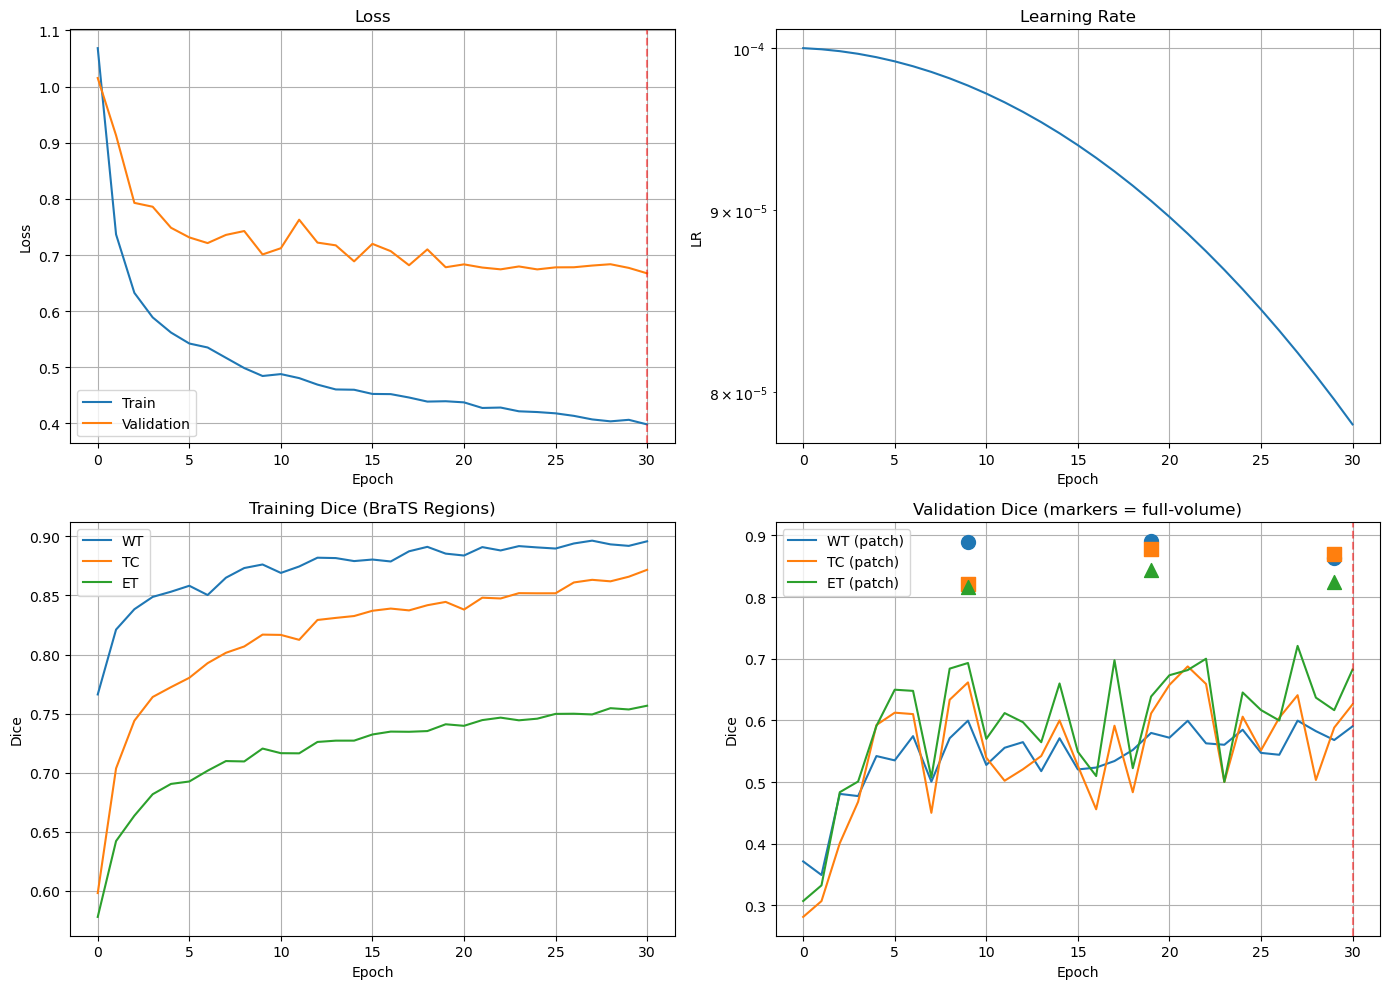

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
ax = axes[0, 0]
ax.plot(history['train_loss'], label='Train')
ax.plot(history['val_loss'], label='Validation')
ax.axvline(best_epoch-1, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss')
ax.legend()
ax.grid(True)

# LR
ax = axes[0, 1]
ax.plot(history['lr'])
ax.set_xlabel('Epoch')
ax.set_ylabel('LR')
ax.set_title('Learning Rate')
ax.set_yscale('log')
ax.grid(True)

# Train Dice (WT/TC/ET)
ax = axes[1, 0]
for region in ['WT', 'TC', 'ET']:
    vals = [d[region] for d in history['train_dice']]
    ax.plot(vals, label=region)
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice')
ax.set_title('Training Dice (BraTS Regions)')
ax.legend()
ax.grid(True)

# Val Dice (WT/TC/ET)
ax = axes[1, 1]
for region in ['WT', 'TC', 'ET']:
    vals = [d[region] for d in history['val_dice']]
    ax.plot(vals, label=f'{region} (patch)')

# Overlay full-volume validation points
if history['val_fullvol']:
    fv_epochs = [(i+1) * CONFIG['full_volume_val_every'] - 1 for i in range(len(history['val_fullvol']))]
    for region, marker in [('WT_Dice', 'o'), ('TC_Dice', 's'), ('ET_Dice', '^')]:
        vals = [m[region] for m in history['val_fullvol']]
        ax.scatter(fv_epochs, vals, marker=marker, s=100, zorder=5)

ax.axvline(best_epoch-1, color='r', linestyle='--', alpha=0.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('Dice')
ax.set_title('Validation Dice (markers = full-volume)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'model6_training_curves.png', dpi=150)
plt.show()

## 8. Test Set Evaluation

In [26]:
# Load best model
checkpoint = torch.load(OUTPUT_DIR / "model6_3d_best.pth", map_location="cpu", weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

Loaded best model from epoch 31


In [27]:
# Full test evaluation
print("Evaluating on test set (full-volume sliding window)...\n")

test_metrics = []

for patient_id in tqdm(test_ids, desc="Test"):
    image, target, affine = load_patient_volume(DATA_DIR, patient_id)
    if target is None:
        continue
    
    pred = sliding_window_inference(
        model, image,
        patch_size=CONFIG['patch_size'],
        overlap=CONFIG['inference_overlap'],
        device=device,
        use_amp=CONFIG['use_amp']
    )
    
    metrics = compute_brats_metrics(pred, target)
    metrics['patient_id'] = patient_id
    test_metrics.append(metrics)

print("\nDone!")

Evaluating on test set (full-volume sliding window)...



Test:   0%|          | 0/56 [00:00<?, ?it/s]/home/sagemaker-user/BraTS-2020-CV-Project/brats_utils_3d.py:577: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Test: 100%|██████████| 56/56 [10:47<00:00, 11.56s/it]


Done!


In [28]:
import pandas as pd

df = pd.DataFrame(test_metrics)

print("\n" + "="*60)
print("TEST SET RESULTS (BraTS Competition Metrics)")
print("="*60)
print()
print("Region       | Dice (mean ± std)      | HD95 (mean ± std)")
print("-" * 60)

for region in ['WT', 'TC', 'ET']:
    dice_col = f'{region}_Dice'
    hd95_col = f'{region}_HD95'
    
    dice_mean = df[dice_col].mean()
    dice_std = df[dice_col].std()
    hd95_mean = df[hd95_col].dropna().mean()
    hd95_std = df[hd95_col].dropna().std()
    
    region_name = {'WT': 'Whole Tumor', 'TC': 'Tumor Core', 'ET': 'Enhancing'}[region]
    print(f"{region_name:12} | {dice_mean:.4f} ± {dice_std:.4f}     | {hd95_mean:.2f} ± {hd95_std:.2f}")

print()
print(f"Test patients: {len(df)}")


TEST SET RESULTS (BraTS Competition Metrics)

Region       | Dice (mean ± std)      | HD95 (mean ± std)
------------------------------------------------------------
Whole Tumor  | 0.8923 ± 0.0792     | 11.07 ± 21.67
Tumor Core   | 0.8496 ± 0.1508     | 11.64 ± 25.18
Enhancing    | 0.7804 ± 0.2487     | 10.13 ± 22.16

Test patients: 55


In [29]:
# Comparison with Model 5
model5_results = {'WT_Dice': 0.6623, 'TC_Dice': 0.7016, 'ET_Dice': 0.7704}

print("\nModel 5 (2D) vs Model 6 (3D):")
print("-" * 50)
for region in ['WT', 'TC', 'ET']:
    m5 = model5_results[f'{region}_Dice']
    m6 = df[f'{region}_Dice'].mean()
    diff = (m6 - m5) / m5 * 100
    symbol = '↑' if diff > 0 else '↓'
    print(f"{region}: {m5:.4f} → {m6:.4f} ({symbol} {abs(diff):.1f}%)")


Model 5 (2D) vs Model 6 (3D):
--------------------------------------------------
WT: 0.6623 → 0.8923 (↑ 34.7%)
TC: 0.7016 → 0.8496 (↑ 21.1%)
ET: 0.7704 → 0.7804 (↑ 1.3%)


# Visualization

Generating visualizations...

Processing BraTS20_Training_050...


/home/sagemaker-user/BraTS-2020-CV-Project/brats_utils_3d.py:577: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  WT: 0.930, TC: 0.946, ET: 0.847


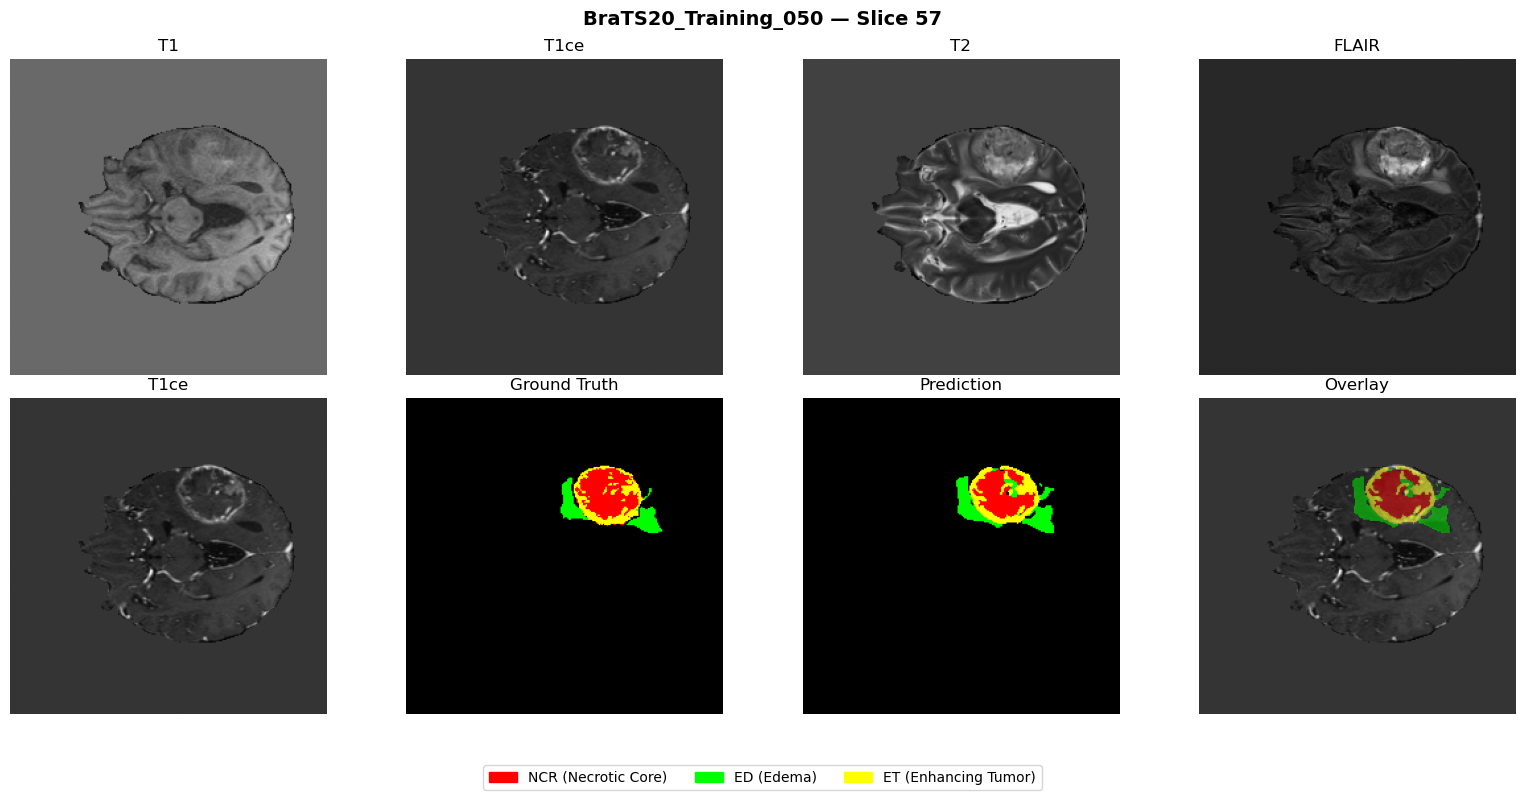

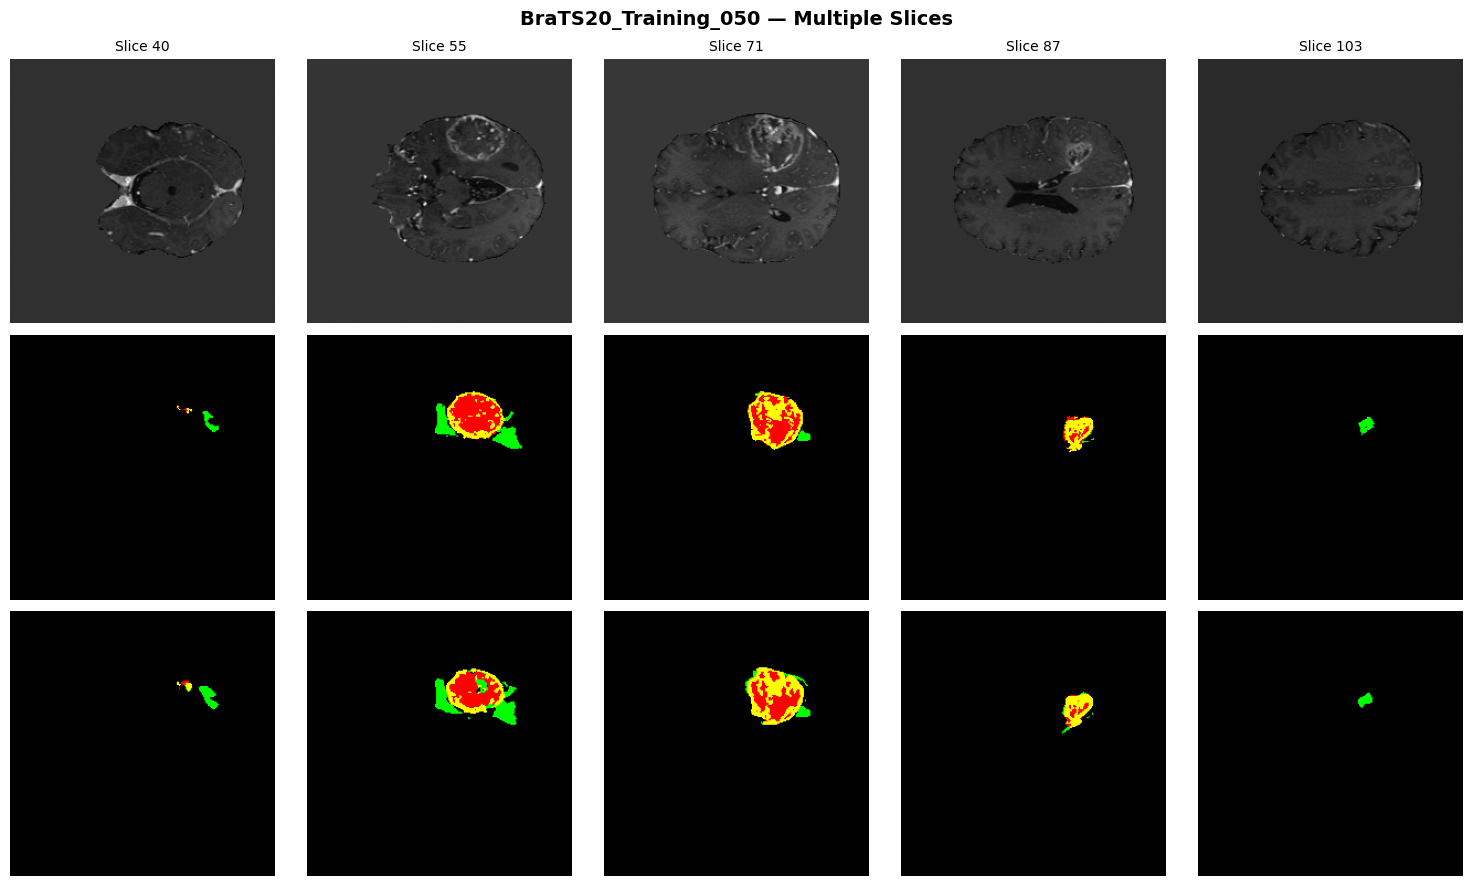


Processing BraTS20_Training_092...
  WT: 0.950, TC: 0.960, ET: 0.944


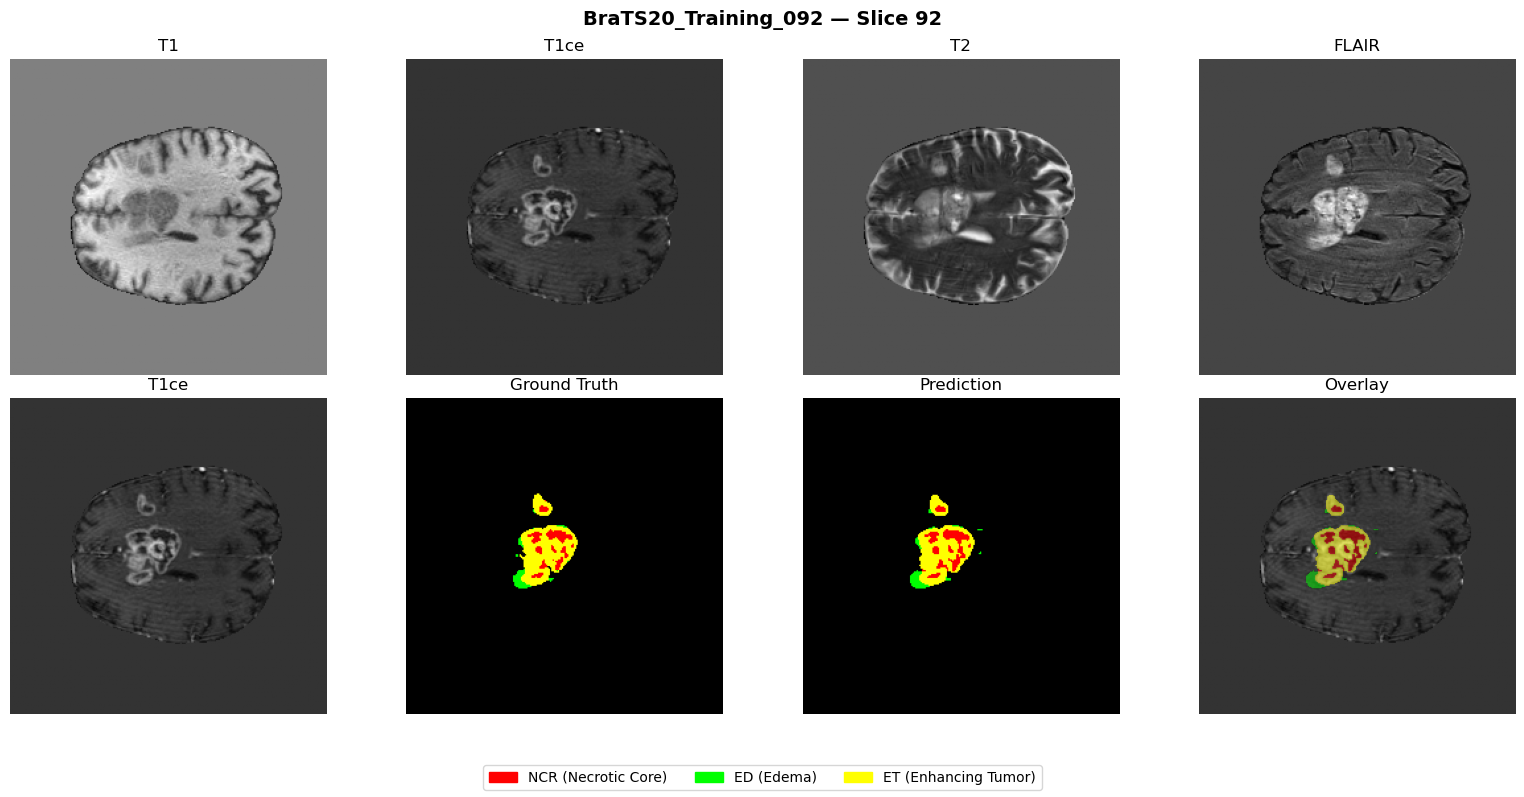

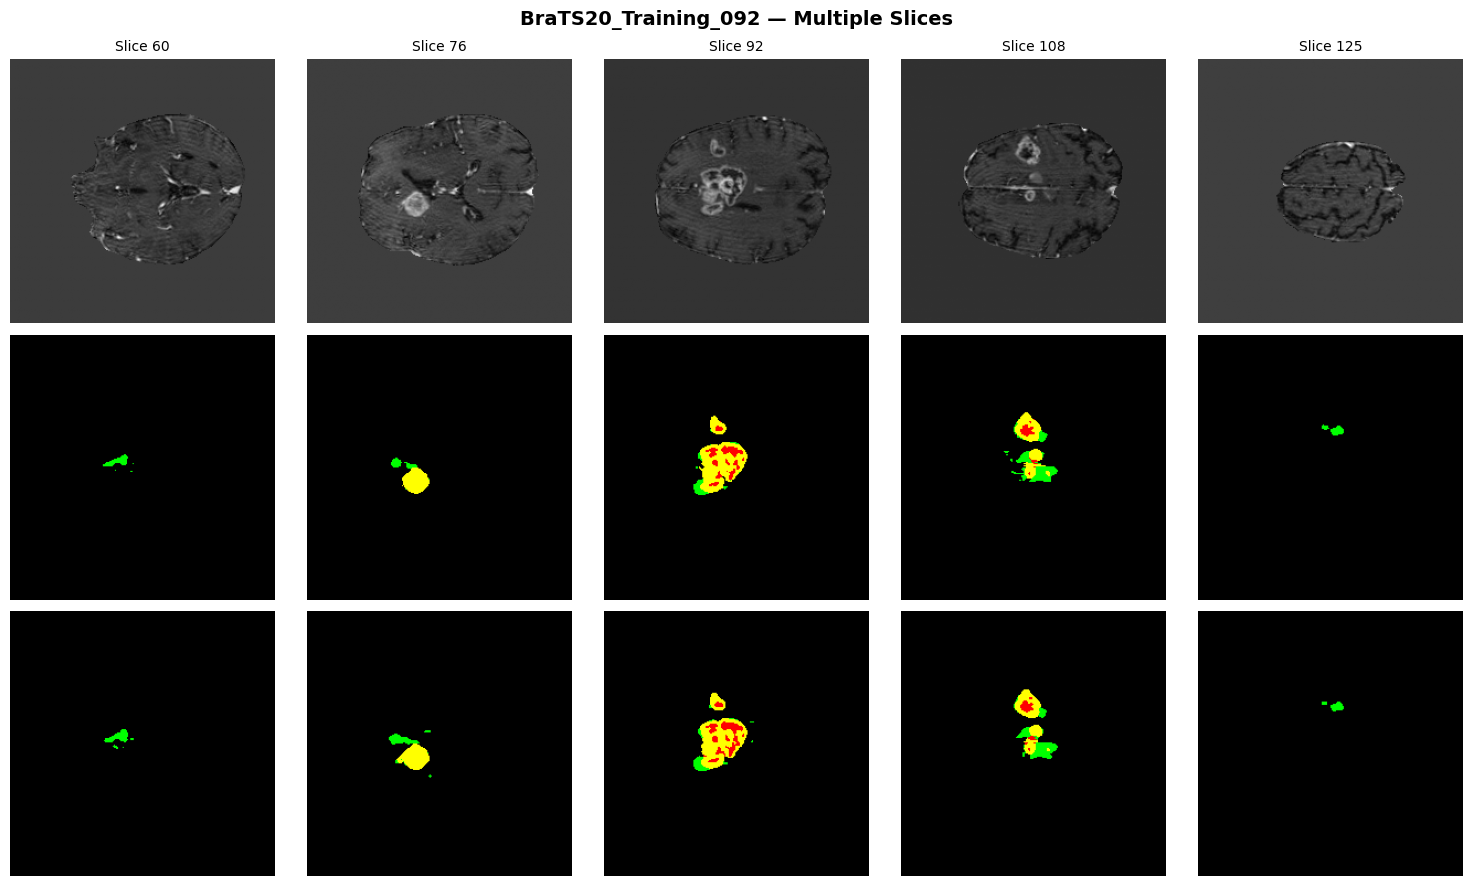


Processing BraTS20_Training_161...
  WT: 0.956, TC: 0.947, ET: 0.894


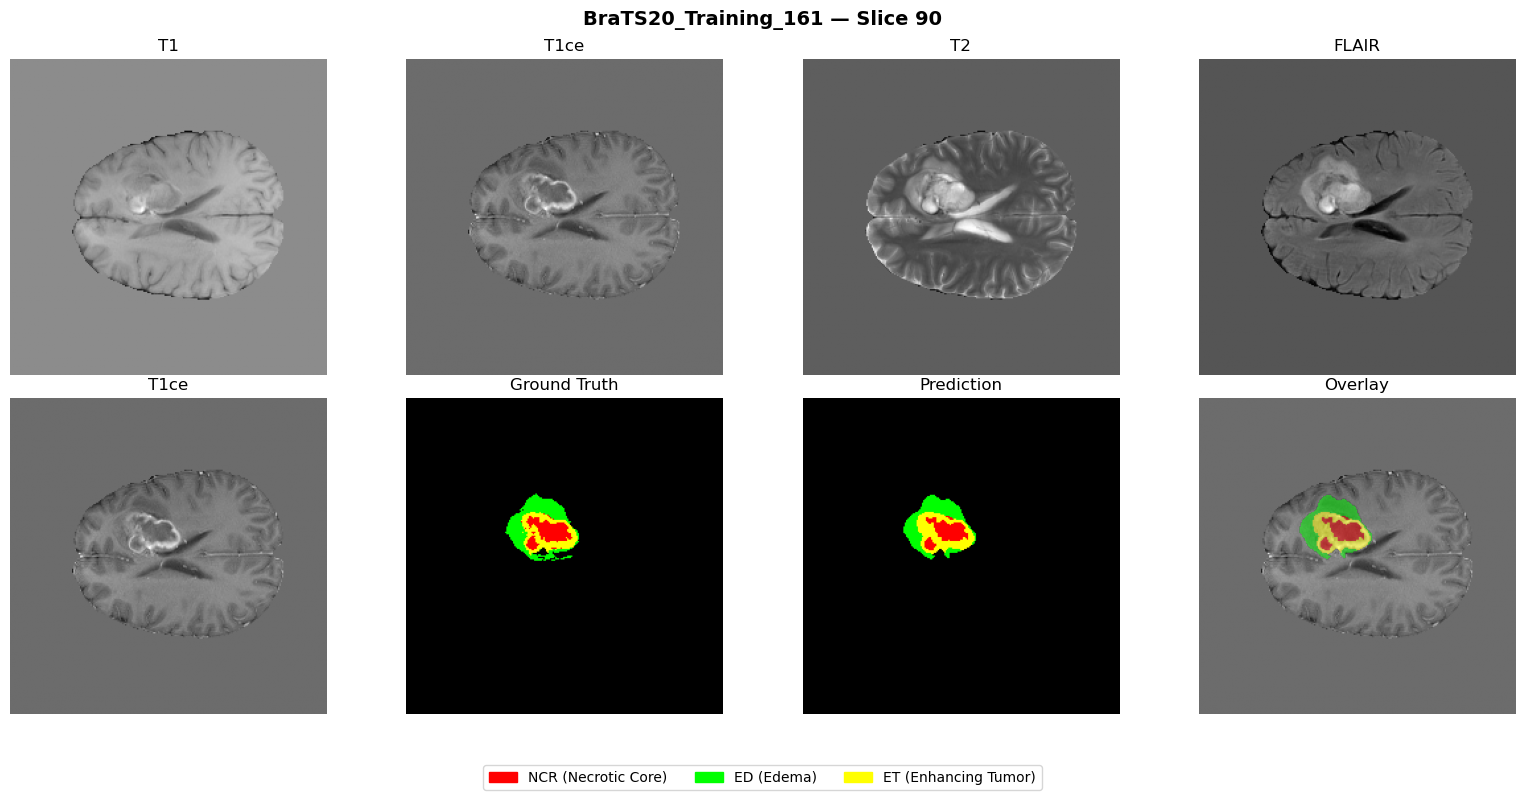

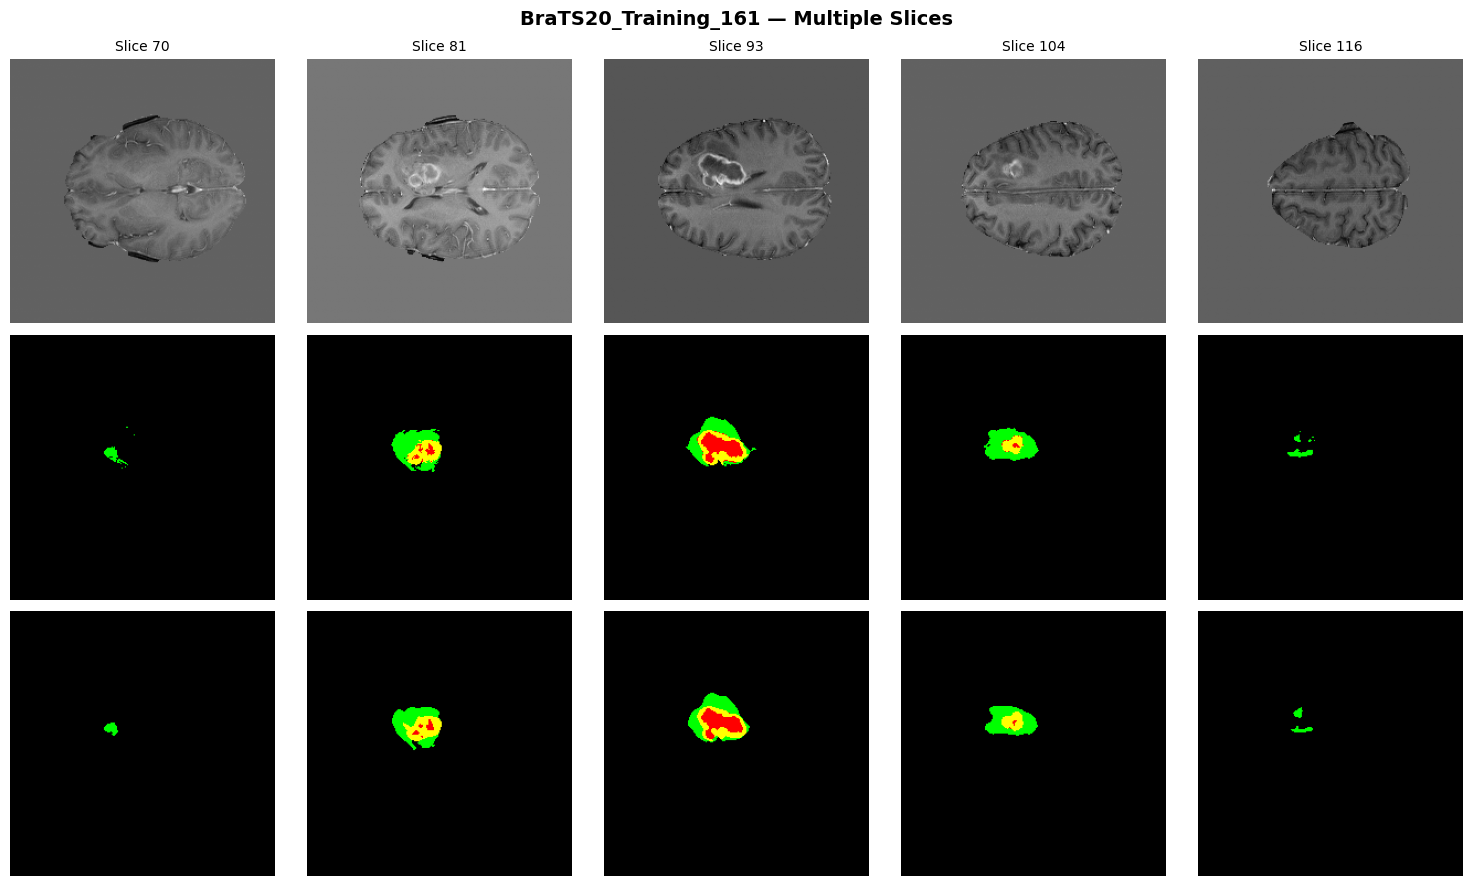


✓ Visualizations saved to output directory


In [30]:
# =============================================================================
# Visualization: Sample Test Predictions
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def visualize_prediction(image, target, pred, patient_id, slice_idx=None):
    """
    Visualize all 4 modalities, ground truth, prediction, and overlay.
    
    Args:
        image: (4, D, H, W) normalized MRI
        target: (D, H, W) ground truth labels
        pred: (D, H, W) predicted labels
        patient_id: string for title
        slice_idx: which slice to show (None = auto-select best)
    """
    # Auto-select slice with most tumor if not specified
    if slice_idx is None:
        tumor_per_slice = [(target[s] > 0).sum() for s in range(target.shape[0])]
        slice_idx = np.argmax(tumor_per_slice)
    
    # Color map for segmentation (0=black, 1=red, 2=green, 3=yellow)
    colors = np.array([
        [0, 0, 0],        # 0: Background - black
        [255, 0, 0],      # 1: NCR - red
        [0, 255, 0],      # 2: ED - green  
        [255, 255, 0],    # 3: ET - yellow
    ]) / 255.0
    
    def label_to_rgb(label_slice):
        rgb = np.zeros((*label_slice.shape, 3))
        for i in range(4):
            rgb[label_slice == i] = colors[i]
        return rgb
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: Four modalities
    mod_names = ['T1', 'T1ce', 'T2', 'FLAIR']
    for i in range(4):
        axes[0, i].imshow(image[i, slice_idx], cmap='gray')
        axes[0, i].set_title(mod_names[i], fontsize=12)
        axes[0, i].axis('off')
    
    # Row 2: T1ce, Ground Truth, Prediction, Overlay
    axes[1, 0].imshow(image[1, slice_idx], cmap='gray')
    axes[1, 0].set_title('T1ce', fontsize=12)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(label_to_rgb(target[slice_idx]))
    axes[1, 1].set_title('Ground Truth', fontsize=12)
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(label_to_rgb(pred[slice_idx]))
    axes[1, 2].set_title('Prediction', fontsize=12)
    axes[1, 2].axis('off')
    
    # Overlay prediction on T1ce
    axes[1, 3].imshow(image[1, slice_idx], cmap='gray')
    mask = pred[slice_idx] > 0
    overlay = np.zeros((*pred[slice_idx].shape, 4))
    for i in range(1, 4):
        overlay[pred[slice_idx] == i, :3] = colors[i]
        overlay[pred[slice_idx] == i, 3] = 0.5  # alpha
    axes[1, 3].imshow(overlay)
    axes[1, 3].set_title('Overlay', fontsize=12)
    axes[1, 3].axis('off')
    
    # Legend
    legend_patches = [
        mpatches.Patch(color=colors[1], label='NCR (Necrotic Core)'),
        mpatches.Patch(color=colors[2], label='ED (Edema)'),
        mpatches.Patch(color=colors[3], label='ET (Enhancing Tumor)'),
    ]
    fig.legend(handles=legend_patches, loc='lower center', ncol=3, fontsize=10)
    
    plt.suptitle(f'{patient_id} — Slice {slice_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    return fig


def visualize_3d_slices(image, target, pred, patient_id, num_slices=5):
    """
    Show multiple slices through the volume.
    """
    # Find slices with tumor
    tumor_per_slice = np.array([(target[s] > 0).sum() for s in range(target.shape[0])])
    tumor_slices = np.where(tumor_per_slice > 100)[0]
    
    if len(tumor_slices) < num_slices:
        selected = tumor_slices
    else:
        # Evenly sample from tumor region
        indices = np.linspace(0, len(tumor_slices)-1, num_slices, dtype=int)
        selected = tumor_slices[indices]
    
    colors = np.array([[0,0,0], [255,0,0], [0,255,0], [255,255,0]]) / 255.0
    
    def label_to_rgb(label_slice):
        rgb = np.zeros((*label_slice.shape, 3))
        for i in range(4):
            rgb[label_slice == i] = colors[i]
        return rgb
    
    fig, axes = plt.subplots(3, len(selected), figsize=(3*len(selected), 9))
    
    for col, s in enumerate(selected):
        # T1ce
        axes[0, col].imshow(image[1, s], cmap='gray')
        axes[0, col].set_title(f'Slice {s}', fontsize=10)
        axes[0, col].axis('off')
        
        # Ground truth
        axes[1, col].imshow(label_to_rgb(target[s]))
        axes[1, col].axis('off')
        
        # Prediction
        axes[2, col].imshow(label_to_rgb(pred[s]))
        axes[2, col].axis('off')
    
    axes[0, 0].set_ylabel('T1ce', fontsize=12)
    axes[1, 0].set_ylabel('Ground Truth', fontsize=12)
    axes[2, 0].set_ylabel('Prediction', fontsize=12)
    
    plt.suptitle(f'{patient_id} — Multiple Slices', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig


# =============================================================================
# Generate Visualizations for 3 Test Patients
# =============================================================================

print("Generating visualizations...")

# Visualize 3 random test patients
np.random.seed(42)
viz_patients = np.random.choice(test_ids, min(3, len(test_ids)), replace=False)

for patient_id in viz_patients:
    print(f"\nProcessing {patient_id}...")
    
    # Load and predict
    image, target, _ = load_patient_volume(DATA_DIR, patient_id)
    pred = sliding_window_inference(
        model, image,
        patch_size=CONFIG['patch_size'],
        overlap=CONFIG['inference_overlap'],
        device=device,
        use_amp=CONFIG['use_amp'],
        batch_size=CONFIG.get('inference_batch_size', 2)
    )
    
    # Compute metrics for this patient
    metrics = compute_brats_metrics(pred, target)
    print(f"  WT: {metrics['WT_Dice']:.3f}, TC: {metrics['TC_Dice']:.3f}, ET: {metrics['ET_Dice']:.3f}")
    
    # Single best slice visualization
    fig1 = visualize_prediction(image, target, pred, patient_id)
    fig1.savefig(OUTPUT_DIR / f'viz_{patient_id}_single.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Multi-slice visualization
    fig2 = visualize_3d_slices(image, target, pred, patient_id)
    fig2.savefig(OUTPUT_DIR / f'viz_{patient_id}_multi.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n✓ Visualizations saved to output directory")

## Next Steps for Model 7+

**If results improve:**
- Add attention mechanisms (SE blocks, attention gates)
- Deeper encoder (5 levels instead of 4)
- Test-time augmentation
- Post-processing (connected components)

**If results don't improve much:**
- Check data augmentation strength
- Try different patch sizes (96³ vs 128³)
- Increase tumor_center_prob early in training
- Add deep supervision

**BraTS Leaderboard Targets:**
- WT Dice: > 0.90
- TC Dice: > 0.85
- ET Dice: > 0.80